<a href="https://colab.research.google.com/github/sebi061/VideoAdEngagement/blob/main/3_Analysis/1_Sports_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Installations ###
#####################

# xg boost
!pip install xgboost

# shap
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
### Import relevant packages ###
################################

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix

In [ ]:
### Set data directory
##################

# connect to drive
from google.colab import drive
drive.mount('/content/drive')

# set data directory
data_dir_feat =  '/content/drive/MyDrive/VideoAdEngagement/1_Extracted_Data/Extracted_Features'
data_dir_stat =  '/content/drive/MyDrive/VideoAdEngagement/1_Downloaded_Data/3_Engagement_Statistics'

Mounted at /content/drive


In [ ]:
### Load and concat all feature files ###
#########################################

# define function
def load_concat_df(level, files):
  for i, file in enumerate(files):
    if i==0:
      df_final = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)
    else:
      df_additional = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)

      df_final = pd.concat([df_final, df_additional], ignore_index=True, axis = 0)

  return df_final


# files
files = ['nike', 'adidas', 'puma', 'underarmour',
         'asics', 'converse', 'timberland', 'salomon',
         'gymshark', 'gopro', 'redbull', 'monsterenergy']


# load feature dfs
low_level_df = load_concat_df(level = 'low_level', files = files)
mid_level_df = load_concat_df(level = 'mid_level', files = files)
high_level_df = load_concat_df(level = 'high_level', files = files)
object_level_df = load_concat_df(level = 'object', files = files)

# concat all
df_feat = low_level_df.merge(mid_level_df, on='video_id').merge(object_level_df, on='video_id').merge(high_level_df, on = 'video_id')

In [ ]:
### Load stats file and merge with feature file ###
###################################################

# load
df_stats = pd.read_csv(os.path.join(data_dir_stat, 'df_sports_stats.csv'), index_col = 0)

# merge
df_full = df_stats.merge(df_feat, on = 'video_id')

{'puma': 0.042461379937335335, 'salomon': 0.027680984866053276, 'monsterenergy': 0.046387200193050634, 'gymshark': 0.03972274995300461, 'adidas': 0.047656850469988826, 'asics': 0.031046005702921743, 'underarmour': 0.026911869381116647, 'nike': 0.038237334513139286, 'redbull': 0.04316218155762098, 'timberland': 0.02688981648085376, 'converse': 0.039190370409335845, 'gopro': 0.04228838647794189}
{'puma': 0.013031257516985112, 'salomon': 0.012633131384185332, 'monsterenergy': 0.01728602048301074, 'gymshark': 0.01203848740515953, 'adidas': 0.010685935301643499, 'asics': 0.013122021408460707, 'underarmour': 0.008896814796641873, 'nike': 0.013151206455209435, 'redbull': 0.015037889400515944, 'timberland': 0.009307881234187108, 'converse': 0.02462663946901246, 'gopro': 0.011668554162791254}


<Axes: ylabel='Density'>

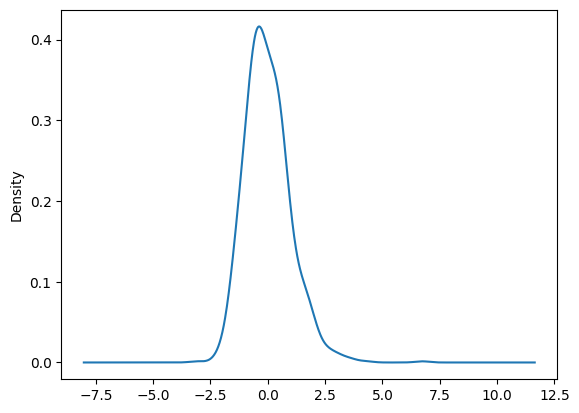

In [ ]:
### Normalization accross all brands ###
########################################

# extract brand means
brand_means = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].mean() for b in set(df_full.brand)}
print(brand_means)

# extract brand stds
brand_std = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].std() for b in set(df_full.brand)}
print(brand_std)

# normalization function
def mu_sig_normalization(example):
  norm_value = (example['eng_score'] - brand_means[example['brand']]) / brand_std[example['brand']]
  #norm_value = example['eng_score'] - brand_means[example['brand']]

  return norm_value

# apply normalization
df_full['norm_eng_score'] = df_full.apply(mu_sig_normalization, axis = 1)

# plot
df_full['norm_eng_score'].plot.kde(bw_method=0.3)

In [ ]:
### Normalize all features accross brands ###
#############################################

# create copy to store normalized values to
df_full_norm = df_full[['video_id', 'brand', 'views', 'likes', 'comments', 'eng_score', 'norm_eng_score']].copy()

# function to subtract feature mean per brand
def feature_mu_sig_norm(example):

  # option 1: mean sigma normalization
  if stds[example[0]] == 0:
    result = example[1] - means[example[0]]

  else:
     result = (example[1] - means[example[0]]) / stds[example[0]]

  # option 2: mu mormalization
  #result = example[1] - means[example[0]]

  return result

# loop over all features to normalize by brand mean
for feat in df_full.columns[6:-1]: # strat at 6

  # get feature mean values per brand
  means = {b: df_full.loc[df_full['brand'] == b, feat].mean() for b in set(df_full.brand)}
  stds =  {b: df_full.loc[df_full['brand'] == b, feat].std() for b in set(df_full.brand)}

  # store to new dataframe
  df_additional = pd.DataFrame({feat:df_full[['brand', feat]].apply(feature_mu_sig_norm, axis = 1)})
  df_full_norm = pd.concat([df_full_norm, df_additional], axis = 1)

In [ ]:
### Define engagement classes ###
#################################

# wrote function
def eng_classes(example):
  if example['norm_eng_score'] < df_full_norm['norm_eng_score'].quantile(1/3):
    cls = 'low'

  elif example['norm_eng_score'] >= df_full_norm['norm_eng_score'].quantile(2/3):
    cls = 'high'

  else:
    cls = 'mid'

  return cls

# apply to df
df_full_norm['eng_class'] = df_full_norm.apply(eng_classes, axis = 1)

# check walue counts
df_full_norm['eng_class'].value_counts()

high    309
mid     308
low     308
Name: eng_class, dtype: int64

# Classification of 3 engagement classes

In [ ]:
### Select all features from dataframe ###
##########################################

ds = df_full_norm.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'mid', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs.best_params_)

# best accuracy score
print(gs.best_score_)

{'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.6000000000000001, 'eta': 0.6000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7999999999999999}
0.4374031007751938


In [ ]:
# best parameters
print(gs.best_params_)

# best accuracy score
print(gs.best_score_)

{'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.6000000000000001, 'eta': 0.6000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7999999999999999}
0.4374031007751938


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs.best_params_
model = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model.fit(X_train, y_train)

# final prediction on test set
y_pred = model.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy mid engagement class: {per_class_acc[1] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[2] * 100:.2f} %")

Total accuracy: 43.53 %
Accuracy low engagement class: 42.05 %
Accuracy mid engagement class: 34.65 %
Accuracy high engagement class: 55.06 %


# Classification of high and low engagment class - 2 way

In [ ]:
### Remove middle class to get clearer distinction ###
######################################################

df_full_norm_2 = df_full_norm.loc[df_full_norm['eng_class'] != 'mid'].reset_index(drop = True)

In [ ]:
### Model fitting and cross validation ###
##########################################
# https://www.anyscale.com/blog/how-to-tune-hyperparameters-on-xgboost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

ds = df_full_norm_2.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_2 = RandomizedSearchCV(estimator=xgbclf_2,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_2.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_2.best_params_)

# best accuracy score
print(gs_2.best_score_)

{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.6000000000000001, 'eta': 0.30000000000000004, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
0.6334498834498835


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters_2 = gs_2.best_params_
model_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_2['learning_rate'],
                     max_depth = best_parameters_2['max_depth'],
                     n_estimators = best_parameters_2['n_estimators'],
                     min_child_weight = best_parameters_2['min_child_weight'],
                     colsample_bytree = best_parameters_2['colsample_bytree'],
                     colsample_bylevel = best_parameters_2['colsample_bylevel'],
                     subsample = best_parameters_2['subsample'],
                     eta = best_parameters_2['eta'],
                     gamma = best_parameters_2['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_2.fit(X_train, y_train)

# final prediction on test set
y_pred = model_2.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 65.59 %
Accuracy low engagement class: 62.64 %
Accuracy high engagement class: 68.42 %


In [ ]:
### Permutation importance ###
##############################

from sklearn.inspection import permutation_importance
r = permutation_importance(model_2, X_train, y_train, n_repeats=10, scoring = "accuracy", random_state=0)
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{df_full_norm.columns[7:-1][i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
r = permutation_importance(model_2, X_test, y_test, n_repeats=10, scoring = "accuracy", random_state=0)
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{df_full_norm.columns[7:-1][i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

p_action_shaving0.019 +/- 0.007
p_sound_mouse_click0.017 +/- 0.005
p_scene_ocean0.016 +/- 0.006
p_sound_church_bells0.015 +/- 0.005
p_sound_can_opening0.015 +/- 0.002
p_action_barking0.015 +/- 0.005
p_scene_desert0.014 +/- 0.006
p_action_combusting/burning0.013 +/- 0.004
hue_part_20.013 +/- 0.006
p_action_overflowing0.012 +/- 0.005
p_sound_rooster0.011 +/- 0.004
p_sound_clapping0.011 +/- 0.006
p_object_dining table0.011 +/- 0.004
p_action_driving0.009 +/- 0.004
sb_part_20.008 +/- 0.004
p_action_snowboarding0.008 +/- 0.004
p_action_sliding0.008 +/- 0.003
p_action_reaching0.008 +/- 0.004
p_action_hitting/colliding0.008 +/- 0.004
p_action_picking0.007 +/- 0.002
p_action_tripping0.005 +/- 0.002
rmse_part_10.005 +/- 0.002
p_action_taping0.005 +/- 0.002
p_sound_dog0.005 +/- 0.002
p_action_climbing0.005 +/- 0.002
p_action_stitching0.005 +/- 0.002


# Train on low level, semantic and psychological features individually

In [ ]:
### low level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_low = df_full_norm_2.iloc[:, 7:34]

In [ ]:
# select x and y variables
X, y = ds_low, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_low = RandomizedSearchCV(estimator=xgbclf_low,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_low.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_low = gs_low.best_params_
model_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_low['learning_rate'],
                     max_depth = best_parameters_low['max_depth'],
                     n_estimators = best_parameters_low['n_estimators'],
                     min_child_weight = best_parameters_low['min_child_weight'],
                     colsample_bytree = best_parameters_low['colsample_bytree'],
                     colsample_bylevel = best_parameters_low['colsample_bylevel'],
                     subsample = best_parameters_low['subsample'],
                     eta = best_parameters_low['eta'],
                     gamma = best_parameters_low['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_low.fit(X_train, y_train)

# final prediction on test set
y_pred = model_low.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 47.31 %
Accuracy low engagement class: 49.45 %
Accuracy high engagement class: 45.26 %


In [ ]:
### Mid level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_mid = df_full_norm_2.iloc[:, 35:506]

In [ ]:
# select x and y variables
X, y = ds_mid, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_mid = RandomizedSearchCV(estimator=xgbclf_mid,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_mid.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_mid = gs_mid.best_params_
model_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_mid['learning_rate'],
                     max_depth = best_parameters_mid['max_depth'],
                     n_estimators = best_parameters_mid['n_estimators'],
                     min_child_weight = best_parameters_mid['min_child_weight'],
                     colsample_bytree = best_parameters_mid['colsample_bytree'],
                     colsample_bylevel = best_parameters_mid['colsample_bylevel'],
                     subsample = best_parameters_mid['subsample'],
                     eta = best_parameters_mid['eta'],
                     gamma = best_parameters_mid['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_mid.fit(X_train, y_train)

# final prediction on test set
y_pred = model_mid.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 61.29 %
Accuracy low engagement class: 57.14 %
Accuracy high engagement class: 65.26 %


In [ ]:
### High level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_high = df_full_norm_2.iloc[:, 507:-1]

In [ ]:
# select x and y variables
X, y = ds_high, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_high = RandomizedSearchCV(estimator=xgbclf_high,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_high.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_high = gs_high.best_params_
model_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_high['learning_rate'],
                     max_depth = best_parameters_high['max_depth'],
                     n_estimators = best_parameters_high['n_estimators'],
                     min_child_weight = best_parameters_high['min_child_weight'],
                     colsample_bytree = best_parameters_high['colsample_bytree'],
                     colsample_bylevel = best_parameters_high['colsample_bylevel'],
                     subsample = best_parameters_high['subsample'],
                     eta = best_parameters_high['eta'],
                     gamma = best_parameters_high['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_high.fit(X_train, y_train)

# final prediction on test set
y_pred = model_high.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 50.00 %
Accuracy low engagement class: 51.65 %
Accuracy high engagement class: 48.42 %


# Cumputing SHAP feature contributions

In [ ]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# sort the normalized engagement scores
s = df_full_norm_2['norm_eng_score'].argsort()

In [ ]:
# sample the 50 observations with the highest and 50 observations with the lowest engagement scores
high_low = list(s[:50]) + list(s[-50:])
len(high_low)

100

In [ ]:
import matplotlib.pyplot as plt

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


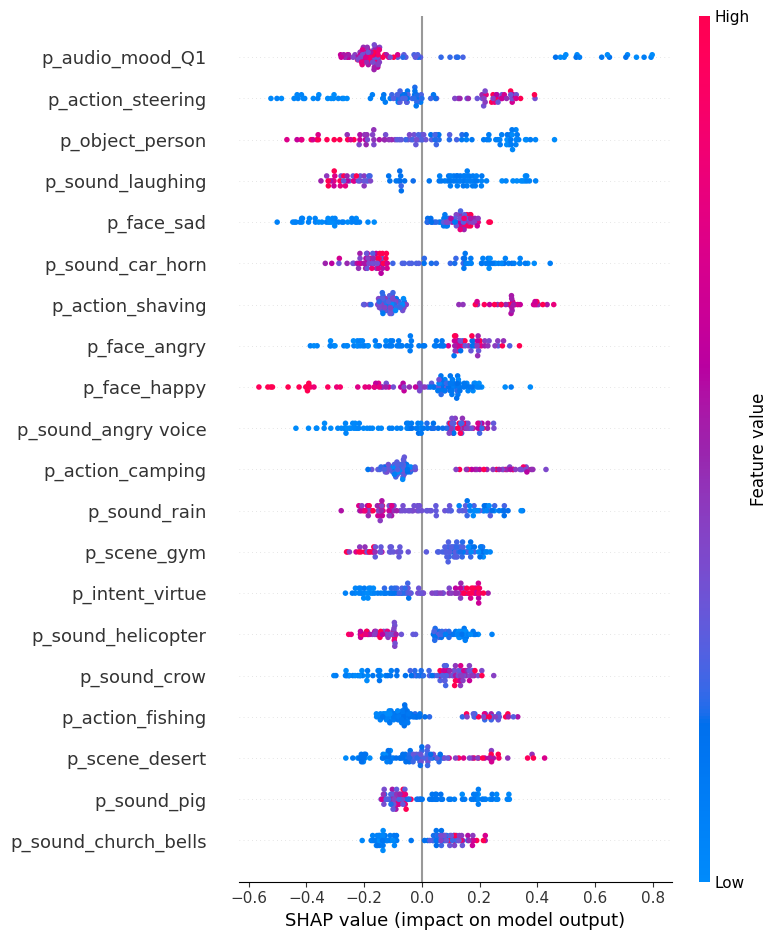

In [ ]:
X_sampled = ds.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape1.png')

# Pca

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# low colour
pca = PCA(n_components=3, random_state = 42)
ds_low_colour = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 7:16]), columns = [f"colour_pc_{i}" for i in range(3)])
ds_low_colour

,colour_pc_0,colour_pc_1,colour_pc_2
0,0.819246,0.881902,-1.778476
1,-0.593782,-1.218682,0.328940
2,-0.832235,-1.664786,0.336006
3,0.003835,-0.718102,-0.165090
4,0.444663,-0.555630,0.060074
...,...,...,...
612,-0.632535,0.206334,0.207431
613,-2.717374,2.506978,0.003895
614,2.745716,-1.471413,2.044692
615,-3.928161,0.008743,-0.065733


In [ ]:
pca = PCA(n_components=2, random_state = 42)
ds_low_dyn = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 16:22]), columns = [f"dynamics_pc_{i}" for i in range(2)])
ds_low_dyn

,dynamics_pc_0,dynamics_pc_1
0,-0.695890,-0.281785
1,0.393938,-1.158637
2,0.218303,-1.227080
3,0.073962,0.176596
4,-0.859822,-1.538209
...,...,...
612,0.337830,0.721439
613,-0.947426,1.675840
614,-1.160150,0.704894
615,-1.466712,0.414445


In [ ]:
pca = PCA(n_components=4, random_state = 42)
ds_low_audio = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 22:34]), columns = [f"audio_pc_{i}" for i in range(4)])
ds_low_audio

,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3
0,-0.689440,-1.818411,-0.079891,-0.346948
1,-1.854739,-0.867026,1.163419,-0.442646
2,-2.779194,-0.176580,0.603583,-1.024533
3,-1.583514,-1.538410,-0.455176,-0.131848
4,-1.855306,-0.777702,0.307160,-0.273507
...,...,...,...,...
612,-3.567716,0.884526,-0.937357,0.658098
613,-1.985477,-1.128301,-0.587723,-1.556492
614,2.822067,-0.617715,-0.030397,0.272617
615,-2.642658,-0.901901,-0.130958,-0.804439


In [ ]:
# mid action
pca = PCA(n_components=10, random_state = 42)
ds_mid_action = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 34:326]), columns = [f"action_pc_{i}" for i in range(10)])
ds_mid_action

,action_pc_0,action_pc_1,action_pc_2,action_pc_3,action_pc_4,action_pc_5,action_pc_6,action_pc_7,action_pc_8,action_pc_9
0,2.552360,1.626373,2.546219,0.659493,1.642333,-0.250401,-0.426737,-0.626868,1.877074,-2.174627
1,2.320219,0.623476,-3.140357,-0.743412,-2.685413,6.593748,1.926270,-5.534307,-0.806844,-1.213170
2,-2.427354,3.770605,0.674412,4.418947,-3.652137,-0.774502,0.254046,0.194802,-1.639807,0.341287
3,1.188459,1.374262,2.834649,-2.238448,2.507736,-2.840076,-0.284913,0.233793,-2.425344,-4.410789
4,-0.590933,0.612093,3.869929,-1.405438,1.629399,-4.011157,1.657649,-0.700067,0.101835,1.022413
...,...,...,...,...,...,...,...,...,...,...
612,-8.676044,-2.112798,-1.276388,1.885215,-3.870973,-0.827548,-4.016316,-2.301148,-0.451757,1.346815
613,-9.119228,-1.773640,-0.727905,-1.049566,-0.615286,-0.714237,1.651127,-0.770290,0.423123,0.973776
614,-10.298454,-0.361538,-1.427447,-0.495122,3.430446,2.277580,2.543735,0.071689,2.219988,2.357266
615,-10.723480,-2.325464,0.257240,-3.444859,-5.124516,-3.878224,0.460469,-1.060780,-0.756832,0.669139


In [ ]:
# mid face
pca = PCA(n_components=4, random_state = 42)
ds_mid_face = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 326:333]), columns = [f"face_pc_{i}" for i in range(4)])
ds_mid_face

,face_pc_0,face_pc_1,face_pc_2,face_pc_3
0,-0.444285,-0.270427,-0.705111,0.309352
1,0.199017,-0.039585,0.936281,-0.488474
2,1.565994,-0.965934,-0.277387,-0.572200
3,0.101250,-0.449499,0.074631,-0.315638
4,0.617786,0.086283,-0.502719,-1.492763
...,...,...,...,...
612,-0.703105,-0.400724,0.489960,-0.440259
613,-0.703105,-0.400724,0.489960,-0.440259
614,-0.703105,-0.400724,0.489960,-0.440259
615,-0.804169,0.592819,-0.114948,2.914334


In [ ]:
# mid scenes
pca = PCA(n_components=10, random_state = 42)
ds_mid_scenes = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 333:372]), columns = [f"scenes_pc_{i}" for i in range(10)])
ds_mid_scenes

,scenes_pc_0,scenes_pc_1,scenes_pc_2,scenes_pc_3,scenes_pc_4,scenes_pc_5,scenes_pc_6,scenes_pc_7,scenes_pc_8,scenes_pc_9
0,0.230047,-0.342764,-0.179145,1.298181,-0.488209,1.529928,-2.921332,-0.266091,-0.067073,1.032532
1,0.444510,-1.744121,-0.025257,-0.133758,-0.840041,0.808956,0.113083,-1.465458,-0.883614,0.311429
2,-2.045929,-2.384429,-0.178286,0.131411,0.399431,-1.419641,1.114795,-0.577436,-0.168871,-1.155500
3,1.600516,-3.027452,1.254608,-1.406409,0.380185,-0.919408,-0.010688,0.749584,-0.531650,-1.195596
4,2.377285,-0.526319,0.744824,-0.502817,-0.653000,0.018760,0.737182,-0.186189,0.470160,-0.857138
...,...,...,...,...,...,...,...,...,...,...
612,-1.539395,2.606252,-0.634954,-1.041645,3.373530,0.382090,-0.444167,3.008124,-1.227505,-0.163945
613,-4.793017,1.494401,1.663519,-1.854735,0.590873,0.162386,0.012864,-0.862777,0.068481,-0.735998
614,-3.244967,0.580208,-0.296921,0.286371,-0.192258,1.240892,-1.038604,-0.720465,0.220897,0.686087
615,0.943564,4.574523,3.708681,7.292032,-1.579550,-3.029093,0.738182,2.629433,-0.406239,-2.803763


In [ ]:
# mid sounds
pca = PCA(n_components=10, random_state = 42)
ds_mid_sounds = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 372:426]), columns = [f"sounds_pc_{i}" for i in range(10)])

In [ ]:
# mid objects
pca = PCA(n_components=10, random_state = 42)
ds_mid_objects = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 426:506]), columns = [f"objects_pc_{i}" for i in range(10)])

In [ ]:
# high intent
pca = PCA(n_components=3, random_state = 42)
ds_high_intent = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 506:515]), columns = [f"intent_pc_{i}" for i in range(3)])
ds_high_intent

,intent_pc_0,intent_pc_1,intent_pc_2
0,-1.922535,0.434142,0.516956
1,-0.038447,0.444877,-1.174574
2,0.346714,0.547033,-0.196742
3,-2.600922,-0.708656,0.905744
4,-2.849567,-1.469342,1.830764
...,...,...,...
612,-0.399550,0.708436,-0.530963
613,-0.621592,0.829384,-0.985940
614,-0.107424,1.847711,0.081441
615,-1.088216,0.548445,0.073087


In [ ]:
# high mem
ds_high_mem = df_full_norm_2.iloc[:, [515]]
ds_high_mem

,mem_score
0,-0.649343
1,0.948908
2,0.624449
3,0.201456
4,0.816781
...,...
612,-1.739276
613,-1.359343
614,-1.195329
615,-0.449722


In [ ]:
# high audio mood
pca = PCA(n_components=2, random_state = 42)
ds_high_audiomood = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 516:-1]), columns = [f"audiomood_pc_{i}" for i in range(2)])
ds_high_audiomood

,audiomood_pc_0,audiomood_pc_1
0,-1.840232,2.447259
1,1.511482,-0.353384
2,1.414320,0.390753
3,-2.080352,-1.182880
4,-0.490463,-0.745636
...,...,...
612,-2.686823,0.777100
613,0.045829,-1.131734
614,0.414183,0.449012
615,-0.366544,-0.067747


In [ ]:
# combining all
ds_pca = pd.concat([ds_low_colour, ds_low_dyn, ds_low_audio, ds_mid_action, ds_mid_face, ds_mid_objects, ds_mid_scenes, ds_mid_sounds, ds_high_intent, ds_high_mem, ds_high_audiomood], ignore_index=False, axis = 1)
ds_pca

,colour_pc_0,colour_pc_1,colour_pc_2,dynamics_pc_0,dynamics_pc_1,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3,action_pc_0,...,sounds_pc_6,sounds_pc_7,sounds_pc_8,sounds_pc_9,intent_pc_0,intent_pc_1,intent_pc_2,mem_score,audiomood_pc_0,audiomood_pc_1
0,0.819246,0.881902,-1.778476,-0.695890,-0.281785,-0.689440,-1.818411,-0.079891,-0.346948,2.552360,...,-2.425716,-2.459265,2.136265,-0.601744,-1.922535,0.434142,0.516956,-0.649343,-1.840232,2.447259
1,-0.593782,-1.218682,0.328940,0.393938,-1.158637,-1.854739,-0.867026,1.163419,-0.442646,2.320219,...,0.874199,-0.173821,-1.360087,-0.963423,-0.038447,0.444877,-1.174574,0.948908,1.511482,-0.353384
2,-0.832235,-1.664786,0.336006,0.218303,-1.227080,-2.779194,-0.176580,0.603583,-1.024533,-2.427354,...,2.748607,-2.669910,1.910725,-1.317685,0.346714,0.547033,-0.196742,0.624449,1.414320,0.390753
3,0.003835,-0.718102,-0.165090,0.073962,0.176596,-1.583514,-1.538410,-0.455176,-0.131848,1.188459,...,1.827126,-1.908641,-1.605438,-0.270521,-2.600922,-0.708656,0.905744,0.201456,-2.080352,-1.182880
4,0.444663,-0.555630,0.060074,-0.859822,-1.538209,-1.855306,-0.777702,0.307160,-0.273507,-0.590933,...,1.127664,-0.091353,-0.924344,0.674676,-2.849567,-1.469342,1.830764,0.816781,-0.490463,-0.745636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-0.632535,0.206334,0.207431,0.337830,0.721439,-3.567716,0.884526,-0.937357,0.658098,-8.676044,...,1.980390,-1.525340,0.452595,0.614868,-0.399550,0.708436,-0.530963,-1.739276,-2.686823,0.777100
613,-2.717374,2.506978,0.003895,-0.947426,1.675840,-1.985477,-1.128301,-0.587723,-1.556492,-9.119228,...,1.675681,-1.414451,-0.638002,2.016104,-0.621592,0.829384,-0.985940,-1.359343,0.045829,-1.131734
614,2.745716,-1.471413,2.044692,-1.160150,0.704894,2.822067,-0.617715,-0.030397,0.272617,-10.298454,...,2.020757,2.408766,-0.538532,-0.333701,-0.107424,1.847711,0.081441,-1.195329,0.414183,0.449012
615,-3.928161,0.008743,-0.065733,-1.466712,0.414445,-2.642658,-0.901901,-0.130958,-0.804439,-10.723480,...,-1.289264,0.194061,0.422350,-0.272204,-1.088216,0.548445,0.073087,-0.449722,-0.366544,-0.067747


# Fit 2 way classification model to the features reduced in dimensions

In [ ]:
### train test split ###
########################

# select x and y variables
X, y = ds_pca, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_3 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_3 = RandomizedSearchCV(estimator=xgbclf_3,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_3.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_3.best_params_)

# best accuracy score
print(gs_3.best_score_)

{'subsample': 0.6, 'n_estimators': 1500, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 0.7000000000000002, 'eta': 0.7000000000000002, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7}
0.6241096866096867


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs_3.best_params_
model_pca = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_pca.fit(X_train, y_train)

# final prediction on test set
y_pred = model_pca.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 60.75 %
Accuracy low engagement class: 68.13 %
Accuracy high engagement class: 53.68 %


In [ ]:
### Checking for the accuracy of the highest and lowest 50 values ###

y_pred = model_pca.predict(ds_pca.iloc[high_low,:])


# acc
acc = accuracy_score(y[high_low], y_pred)

matrix = confusion_matrix(y[high_low], y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 87.00 %
Accuracy low engagement class: 92.00 %
Accuracy high engagement class: 82.00 %


# Shap

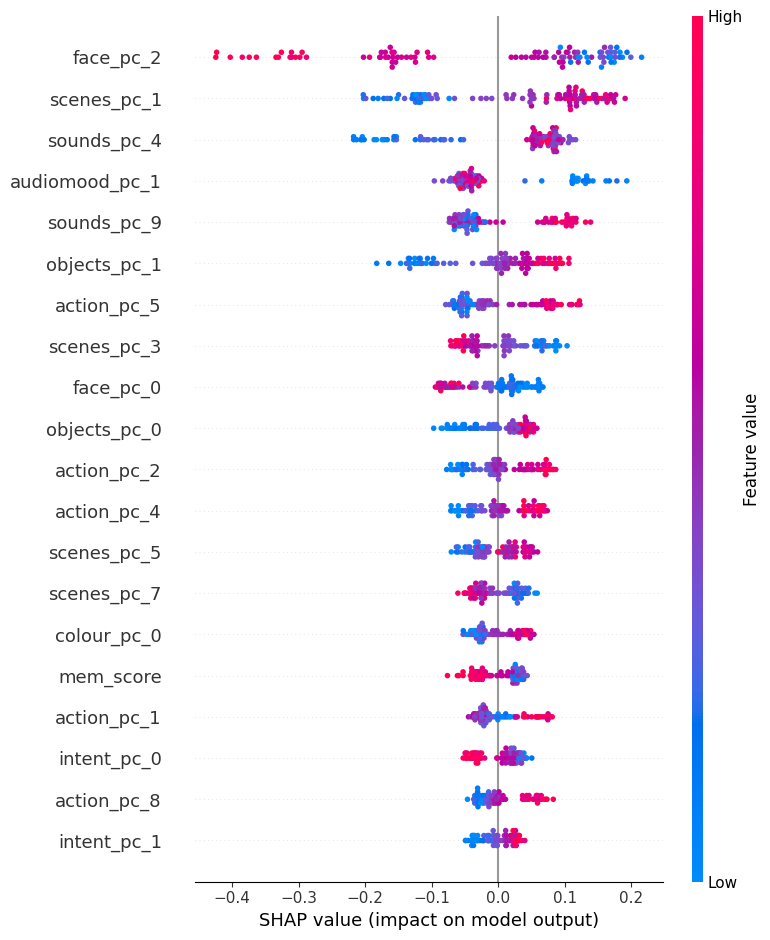

In [ ]:
X_sampled = ds_pca.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_pca)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape2.png')